# Coursera Capstone - Battle of Zurich
IBM Data Science Professional Certificate - Markus Kessler  
<br/><br/>
  
## Problem Description
Working with all of this loacation based data in the previous lessions, i wonderd if i could implement a regression to predict the pricing of flats around the city of Zurich, Switzerland. The Importance of price-predicting in our fast expanding society is obiquitous and i wonder if i can discover what exactly has an impact on the price of a flat. Nowing what price will come out from data that may be based only on the location can give extreme insight if for instance a bank or a coorporation should invest in a real estate project. 

## Data Description
The data used is scraped off of one of the biggest real estate platform of switzerland, namely ImmoScout24.ch. I want to see if i can form a precise model based on this source as well as additionally generated data like Foursquare Point-Of-Interests, distance to the main station or onehot-encoding derived from the description of a flat i.e. looking for keywords like "new" or "lakeview".

In the process a exploratively application of clustering may show us if flats can be put into groupes, but this will certanly  be more informative rather than the main goal of this assingment.

In [50]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from geopy.distance import distance
pd.set_option('display.max_columns', None)

In [51]:
url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-zuerich?pn=2&r=10'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
raw_data = soup.find(id='state')

jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
#raw_data.string.replace('undefined', 'null')


In [52]:
f = open("sample.txt", "w")
f.write(json.dumps(jason_data))
f.close()

In [53]:
# getting the published empty flats of Zurich in a 10km radius
# IF THIS CELL RETURNS AN ERROR, IT MIGHT CHECK FOR MORE PAGES THAN AVAILABLE
result_list = []
max = 39 #number of web pages to scrape

for i in range(max):
    url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-zuerich?pn={}&r=10'.format(i+1)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_data = soup.find(id='state')
    jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
    data_list = jason_data['pages']['searchResult']['resultData']['listData']

    page_list = []

    for elem in data_list:
        if 'price' in elem: price = elem['price']
        else: price = np.nan

        if 'surfaceLiving' in elem: sl = elem['surfaceLiving']
        else: sl = np.nan

        if 'numberOfRooms' in elem: nor = elem['numberOfRooms']
        else: nor = np.nan

        if 'title' in elem: ttl = elem['title']
        else: ttl = np.nan

        if 'latitude' in elem: lat = elem['latitude']
        else: lat = np.nan

        if 'longitude' in elem: lon = elem['longitude']
        else: lon = np.nan

        page_list.append([elem['id'], price, nor, sl, ttl, elem['zip'], lat, lon])

    result_list += page_list

result_list[10:12]

[[6293799, 1930, 2.5, nan, 'Schöne Aussicht', '8600', 47.40102, 8.61187],
 [6308659,
  1620,
  3.5,
  71,
  'Wohnung in zentralem Wohngebiet',
  '8902',
  47.39086,
  8.41922]]

In [54]:
flats_df = pd.DataFrame(result_list)
flats_df.columns = ['ID', 'Price', 'RoomNr', 'Surface', 'Title', 'ZIP', 'Latitude', 'Longitude']

flats_df.dropna(inplace=True)
flats_df['Title'] = flats_df['Title'].str.lower()

flats_df['Vista'] = 0
filter1 = flats_df['Title'].str.contains('blick|sicht|anstoss')
filter2 = ~flats_df['Title'].str.contains('besichtigung')
flats_df.loc[filter1 & filter2, 'Vista'] = 1

flats_df['Bright'] = 0
filter3 = flats_df['Title'].str.contains("hell|licht|sonnig")
flats_df.loc[filter3, 'Bright'] = 1

flats_df['New'] = 0
filter4 = flats_df['Title'].str.contains("neu|new")
flats_df.loc[filter4, 'New'] = 1

flats_df['Furnished'] = 0
filter5 = flats_df['Title'].str.contains("möbliert|moebliert|furnished")
flats_df.loc[filter5, 'Furnished'] = 1

#flats_df['Furnished'].value_counts()
flats_df.describe()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished
count,8.170000e+02,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000
mean,6.053715e+06,2520.233782,2.932069,73.899633,47.388673,8.534509,0.055080,0.066095,0.061200,0.145655
std,5.644865e+05,1344.466711,1.242122,37.753064,0.034289,0.053834,0.228275,0.248601,0.239843,0.352976
min,2.141913e+06,450.000000,1.000000,1.000000,47.290900,8.404090,0.000000,0.000000,0.000000,0.000000
25%,6.091092e+06,1790.000000,2.000000,47.000000,47.366660,8.503170,0.000000,0.000000,0.000000,0.000000
50%,6.259493e+06,2210.000000,3.000000,70.000000,47.387540,8.541520,0.000000,0.000000,0.000000,0.000000
75%,6.297050e+06,2849.000000,3.500000,96.000000,47.412360,8.564520,0.000000,0.000000,0.000000,0.000000
max,6.315199e+06,19000.000000,7.500000,284.000000,47.467300,8.661140,1.000000,1.000000,1.000000,1.000000


In [55]:
#Adding each flats distance to the Zurich Main Station
def get_station_dist(lat, lon):
    return distance((lat,lon), (47.378,8.540)).kilometers

def row_function(row):
    return get_station_dist(row['Latitude'], row['Longitude'])

flats_df['StationDist'] = flats_df.apply(row_function, axis = 1)
flats_df.head()


,ID,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist
0,6302686,4998.0,4.5,124.0,"4.5-zimmer-wohnung, 12. og, l12.2, 124.6 m2",8004,47.37942,8.53178,0,0,0,0,0.640510
1,6303728,3230.0,4.5,114.0,helle wohnung im wunderschönen neubau ankenbüel!,8126,47.32661,8.63261,0,1,1,0,9.033425
2,5879775,1779.0,2.5,74.0,sanierte wohnung in oberengstringen,8102,47.40759,8.45742,0,0,0,0,7.049249
3,6313462,5440.0,5.5,175.0,erstbezug nach einer aufwändigen renovation in...,8700,47.32536,8.58065,0,0,0,0,6.609356
4,6273375,2830.0,4.5,117.0,helle wohnung mit 3.82 m hohem wohnzimmer und ...,8952,47.39899,8.44628,0,1,0,0,7.451010


In [56]:
#Cleaning out statistical outliers
flats_filtered = flats_df[flats_df['Surface'] > 3 ]
flats_filtered.corr()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist
ID,1.000000,-0.020832,0.113225,0.103962,0.069686,0.095056,-0.001417,0.017748,0.063474,-0.297874,0.037045
Price,-0.020832,1.000000,0.471618,0.637114,-0.224607,0.056502,0.136956,-0.035646,0.048455,0.085687,-0.295449
RoomNr,0.113225,0.471618,1.000000,0.865105,-0.006884,0.032208,0.142705,0.067917,0.170118,-0.263005,0.344730
Surface,0.103962,0.637114,0.865105,1.000000,-0.037128,0.033590,0.139181,0.064732,0.176837,-0.233657,0.217142
Latitude,0.069686,-0.224607,-0.006884,-0.037128,1.000000,-0.026814,-0.069348,-0.033499,-0.023184,-0.131860,0.277223
Longitude,0.095056,0.056502,0.032208,0.033590,-0.026814,1.000000,-0.014775,-0.001322,0.008216,0.036533,-0.141267
Vista,-0.001417,0.136956,0.142705,0.139181,-0.069348,-0.014775,1.000000,-0.021120,0.027817,-0.084613,0.047209
Bright,0.017748,-0.035646,0.067917,0.064732,-0.033499,-0.001322,-0.021120,1.000000,0.055317,-0.096028,0.132112
New,0.063474,0.048455,0.170118,0.176837,-0.023184,0.008216,0.027817,0.055317,1.000000,-0.105567,0.191193
Furnished,-0.297874,0.085687,-0.263005,-0.233657,-0.131860,0.036533,-0.084613,-0.096028,-0.105567,1.000000,-0.320293


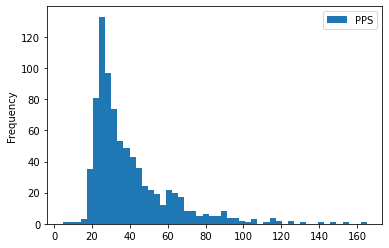

In [57]:
#Calculating price per squaremeter
pps = flats_filtered['Price'] / flats_filtered['Surface']
flats_filtered['PPS'] = pps
flats_filtered[['PPS']].plot.hist(bins=50)

In [58]:
cluster_df = flats_filtered.set_index('ID')
cluster_df = cluster_df[['PPS', 'StationDist', 'Vista']]
#cluster_df.dropna(inplace=True)
X = normalize(cluster_df.to_numpy())
#X = cluster_df.to_numpy()
clusters = KMeans(n_clusters=3).fit_predict(X)

In [59]:
flats_final = flats_filtered
flats_final['Cat'] = np.array(clusters)
flats_final[flats_final['Cat']==2].describe()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS,Cat
count,1.910000e+02,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.0
mean,6.053158e+06,2084.591623,3.787958,92.324607,47.399323,8.516198,0.062827,0.136126,0.104712,0.005236,8.505592,23.088896,2.0
std,5.466155e+05,522.148588,0.821303,26.585104,0.045904,0.082582,0.243290,0.343823,0.306987,0.072357,1.045897,3.515287,0.0
min,2.926781e+06,700.000000,1.500000,42.000000,47.290900,8.404090,0.000000,0.000000,0.000000,0.000000,5.751609,4.375000,2.0
25%,6.107295e+06,1747.500000,3.500000,73.000000,47.375510,8.440890,0.000000,0.000000,0.000000,0.000000,7.815673,20.879806,2.0
50%,6.246189e+06,2045.000000,3.500000,90.000000,47.408710,8.482220,0.000000,0.000000,0.000000,0.000000,8.495625,23.411765,2.0
75%,6.293496e+06,2297.500000,4.500000,104.000000,47.439900,8.592090,0.000000,0.000000,0.000000,0.000000,9.257991,25.148573,2.0
max,6.315149e+06,4800.000000,6.500000,231.000000,47.467300,8.653510,1.000000,1.000000,1.000000,1.000000,10.697431,33.968254,2.0


In [60]:
# create map of zurich using latitude and longitude values
map_zurich = folium.Map(location=[47.38, 8.53], zoom_start=11.5)

linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=2
)

# add markers to map
for lat, lng, id, cat in zip(flats_final['Latitude'], flats_final['Longitude'], flats_final.index, flats_final['Cat']):
    label = folium.Popup(str(id), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(cat),
        fill=True,
        fill_color=linear(cat),
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)

map_zurich

In [64]:
flats_sample = flats_final.sample(100, random_state=5)
flats_sample


,ID,Price,RoomNr,Surface,Title,ZIP,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS,Cat
29,6299105,1690.0,2.5,48.0,zentrale und helle 2.5 zimmerwohnung,8048,47.38907,8.48328,0,1,0,0,4.456255,35.208333,0
256,6283271,1780.0,1.0,20.0,ein zuhause für singels,8003,47.37280,8.51547,0,0,0,0,1.940659,89.000000,1
508,6232729,2290.0,1.5,38.0,modern und zentral,8048,47.38649,8.50296,0,0,0,0,2.951938,60.263158,1
374,5994352,1990.0,3.5,83.0,zentraler geht nicht!,8902,47.38330,8.42143,0,0,0,0,8.973080,23.975904,2
272,6266202,1810.0,2.5,66.0,"super wohnlage in altstetten - grün, ruhig und...",8048,47.39049,8.46845,0,0,0,0,5.578271,27.424242,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,6290492,9800.0,7.0,257.0,exklusives wohnen im roten schloss - ihr sanie...,8002,47.36500,8.53732,0,0,0,0,1.459420,38.132296,1
235,6129705,1725.0,3.5,68.0,3.5 zimmer-wohnung in adliswi zu vermieten,8134,47.30415,8.52135,0,0,0,0,8.330546,25.367647,2
735,6013821,3300.0,5.0,108.0,5 zimmerwohnung mit seesicht,8700,47.31121,8.59086,1,0,0,0,8.361188,30.555556,0
12,6302225,2410.0,3.5,86.0,exklusiv wohnen im leutschentower,8050,47.41638,8.55602,0,0,0,0,4.435102,28.023256,0


In [65]:
CLIENT_ID = 'VV5H111QRCSXOLD5LF52CDDBI1S1QPDX5BFBOI3IJQHGYI4L' # your Foursquare ID
CLIENT_SECRET = 'TEH4SQMZBUB1VHCJZQYNLNHCQTBLTEXIHBLY1VWM1FMSYU1N' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 500
LIMIT = 50

In [66]:
venues_list=[]

for flatID, flatLat, flatLon in zip(flats_sample['ID'], flats_sample['Latitude'], flats_sample['Longitude']):

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, flatLat, flatLon, VERSION, RADIUS, LIMIT)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        venues_list.append([
            flatID,
            v['venue']['categories'][0]['name']
        ])

venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['ID', 'Category']

onehot_data = pd.get_dummies(venues_df['Category'],  prefix="", prefix_sep="")
onehot_data['ID'] = venues_df['ID']
onehot_data = onehot_data.groupby('ID').sum()
onehot_data

KeyError: 'groups'

In [16]:
onehot = onehot_data.reset_index()
onehot = onehot.groupby('ID').sum()
#onehot.drop('index', inplace=True)
onehot

,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bathing Area,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hill,History Museum,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nightclub,Office,Opera House,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Park,Pedestrian Plaza,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Pub,Racetrack,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trade School,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Waterfront,Wine Bar,Wine Shop
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3361838,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3412711,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
3647140,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,1,2,

In [17]:
pois = [
    'Bus Station',
    'Bus Stop',
    'Convenience Store',
    'Discount Store',
    'Grocery Store',
    'Food',
    'Café',
    'Light Rail Station',
    'Market',
    'Shopping Mall',
    'Supermarket',
    'Train Station',
    'Tram Station'
]

#onehot = onehot[pois]
onehot['sum'] = onehot.sum(axis=1)
onehot

,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bathing Area,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Hill,History Museum,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Medical Center,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nightclub,Office,Opera House,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Park,Pedestrian Plaza,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Pub,Racetrack,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Ski Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Trade School,Train Station,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Waterfront,Wine Bar,Wine Shop,sum
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3361838,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24
3412711,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,14
3647140,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0

In [33]:
fs = flats_sample.set_index('ID')
flats_joined = fs.join(onehot['sum'], how='left')
flats_joined.rename(columns={'sum':'POIS'}, inplace=True)
flats_joined.corr()
#flats_joined['sum'].value_counts()


#filter = flats_joined['RoomNr'] == 3.5
#flats_filtered = flats_joined[filter]


#plt.scatter(flats_joined['POIS'], flats_joined['PPS'])
flats_joined.corr()

,Price,RoomNr,Surface,Latitude,Longitude,Vista,Bright,New,Furnished,StationDist,PPS,Cat,POIS
Price,1.000000,0.552908,0.726336,-0.161503,0.081812,0.176961,-0.107296,-0.037142,0.003772,-0.350914,0.055288,0.247886,0.350750
RoomNr,0.552908,1.000000,0.909985,0.082618,0.055145,0.270460,0.122413,0.117333,-0.340333,0.358493,-0.619848,-0.269960,-0.315136
Surface,0.726336,0.909985,1.000000,0.056785,0.065615,0.186141,0.043771,0.121357,-0.305895,0.209924,-0.548613,-0.198164,-0.140859
Latitude,-0.161503,0.082618,0.056785,1.000000,0.168599,-0.087596,0.040662,-0.177438,-0.180806,0.316248,-0.224176,-0.287761,-0.232861
Longitude,0.081812,0.055145,0.065615,0.168599,1.000000,0.087204,0.088754,-0.076996,0.014468,-0.054433,-0.040172,-0.108577,0.026051
Vista,0.176961,0.270460,0.186141,-0.087596,0.087204,1.000000,0.116890,-0.057961,-0.107486,0.064810,-0.074322,0.011174,-0.162623
Bright,-0.107296,0.122413,0.043771,0.040662,0.088754,0.116890,1.000000,0.095719,-0.128540,0.157946,-0.178974,-0.148904,-0.174403
New,-0.037142,0.117333,0.121357,-0.177438,-0.076996,-0.057961,0.095719,1.000000,-0.118370,0.151395,-0.158846,-0.254322,-0.219767
Furnished,0.003772,-0.340333,-0.305895,-0.180806,0.014468,-0.107486,-0.128540,-0.118370,1.000000,-0.404186,0.389995,0.352454,0.475604
StationDist,-0.350914,0.358493,0.209924,0.316248,-0.054433,0.064810,0.157946,0.151395,-0.404186,1.000000,-0.645881,-0.636104,-0.775660


In [69]:
flats_data = flats_joined.dropna()
X = flats_data[['StationDist', 'POIS', 'RoomNr']]
Y = flats_data[['PPS']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
X.count()

StationDist    99
POIS           99
RoomNr         99
dtype: int64

In [70]:
linMod = LinearRegression(normalize=True)
linMod.fit(X_train, Y_train)

print ('Coefficients: ', linMod.coef_)

Coefficients:  [[-2.42168976  0.24264744 -7.173149  ]]


In [71]:
Y_hat = linMod.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((Y_hat - Y_test) ** 2))
print('Variance score: %.2f' % linMod.score(X_test, Y_test))

Residual sum of squares: 64.93
Variance score: 0.77
